# Tracking a computational experiment: conformer generation

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import rdDistGeom
import os
import rdkit
print(rdkit.__version__)
%load_ext sql

2023.03.1


Some data from ChEMBL

In [2]:
import pandas as pd
from io import StringIO
txt = '''"standard_relation","standard_value","standard_type","pchembl_value","assay_chembl_id","target_chembl_id","canonical_smiles","compound_chembl_id"
">",10000.0,"Ki",,"CHEMBL615807","CHEMBL214","CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\C=C/C(=O)O","CHEMBL1794855"
"=",168.0,"Ki",6.78,"CHEMBL615460","CHEMBL214","CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C","CHEMBL278751"
"=",181.0,"Ki",6.74,"CHEMBL615809","CHEMBL214","C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4","CHEMBL103772"
"=",3.9,"Ki",8.41,"CHEMBL615460","CHEMBL214","CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23","CHEMBL328107"
"=",1.6,"Ki",8.8,"CHEMBL615756","CHEMBL214","COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C4)c5csc6ccccc56)Oc12","CHEMBL148860"
"=",210.0,"Ki",6.68,"CHEMBL615460","CHEMBL214","CCCN(CCC)C1CCc2c(C1)ccc3ccoc23","CHEMBL96735"
"=",1.7,"Ki",8.77,"CHEMBL616120","CHEMBL214","CCc1cccc(OC[C@@H](O)CN2CCC3(CC2)OCc4c3ccc5ccccc45)c1","CHEMBL111065"
"=",344.0,"Ki",6.46,"CHEMBL615460","CHEMBL214","CCCN(CCC)C1CCc2c(O)cccc2C1","CHEMBL273273"
"=",127.7,"Ki",6.89,"CHEMBL615756","CHEMBL214","COc1cccc2OC[C@H](CN3C4CCC3C=C(C4)n5ccc6cc(F)ccc56)Oc12","CHEMBL150050"
"=",5.87,"Ki",8.23,"CHEMBL615756","CHEMBL214","CCOc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C4)c5ccc6ccccc6c5)Oc12","CHEMBL151786"
'''
sio = StringIO(txt)
df = pd.read_csv(sio)
df.head()

standard_relation  standard_value standard_type  pchembl_value   
0                 >         10000.0            Ki            NaN  \
1                 =           168.0            Ki           6.78   
2                 =           181.0            Ki           6.74   
3                 =             3.9            Ki           8.41   
4                 =             1.6            Ki           8.80   

  assay_chembl_id target_chembl_id   
0    CHEMBL615807        CHEMBL214  \
1    CHEMBL615460        CHEMBL214   
2    CHEMBL615809        CHEMBL214   
3    CHEMBL615460        CHEMBL214   
4    CHEMBL615756        CHEMBL214   

                                    canonical_smiles compound_chembl_id  
0  CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\...      CHEMBL1794855  
1             CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C       CHEMBL278751  
2          C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4       CHEMBL103772  
3               CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23       CHEMBL328107  
4  COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C...       CHEMBL148860

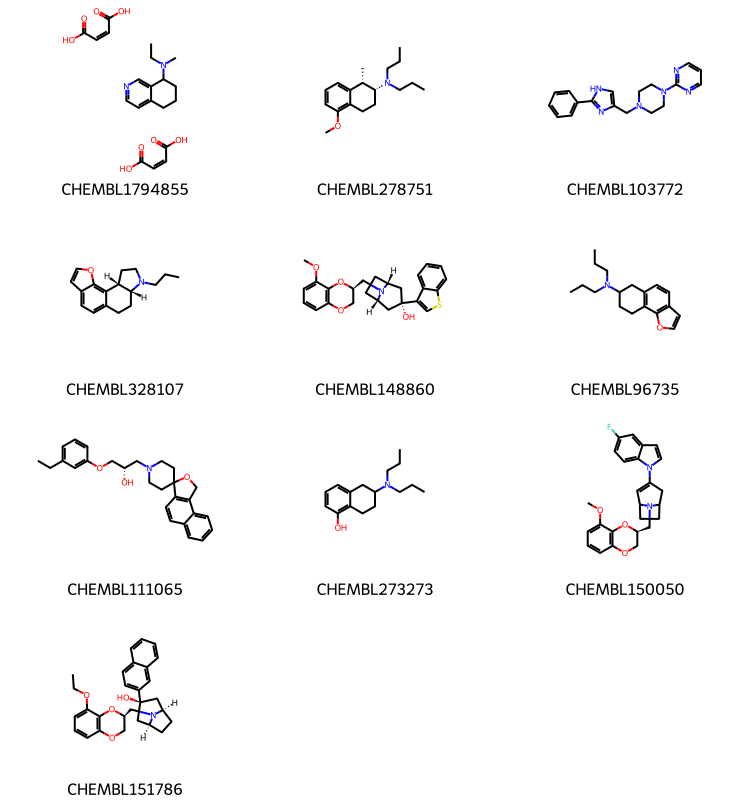

In [3]:
ms = [Chem.MolFromSmiles(smi) for smi in df.canonical_smiles]
Draw.MolsToGridImage(ms,legends=list(df.compound_chembl_id),molsPerRow=3,subImgSize=(250,200))

In [4]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils

config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbtype'] = 'postgresql'
config['dbname'] = 'dbname=lwreg_experiments_demo host=localhost'
# be explicit about what our standardization is:
config['standardization'] = standardization_lib.ChargeParent()


Initialize the database. **Note** that this erases everything in the current database, so be very careful with this command!

In [5]:
lwreg.initdb(config=config,confirm='yes')

True

Register all of our compounds at once:

In [6]:
# The RDKit standardizer is quite verbose by default, make it be quiet:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')

In [7]:
# now bulk register. We want to also collect IDs of compounds which were already registered.
reg_ids = lwreg.bulk_register(mols=ms,config=config,failOnDuplicate=False)
reg_ids = set(reg_ids)
print(f'Registered {len(reg_ids)} unique compounds.')

Registered 10 unique compounds.


Get the registered mol blocks.

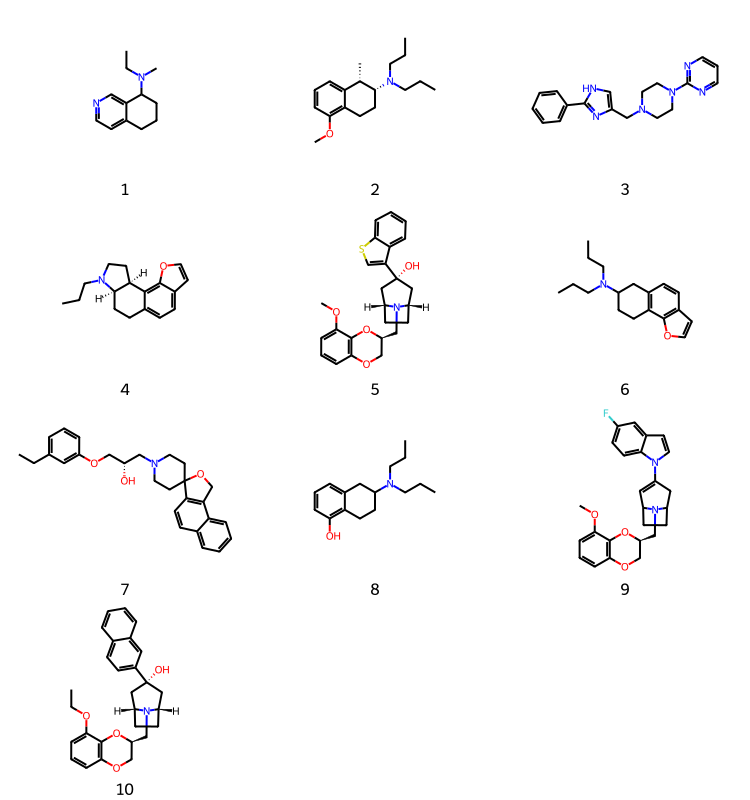

In [8]:
mol_data = lwreg.retrieve(ids=list(reg_ids),config=config)
mids,new_mols = zip(*[(mid,Chem.MolFromMolBlock(d)) for mid,d,_ in mol_data])
Draw.MolsToGridImage(new_mols,legends=[str(x) for x in mids],molsPerRow=3,subImgSize=(250,200))

# Set up database to hold experiments and results:

Initialize the experiment database:

In [9]:
cn = utils._connect(config)
curs = cn.cursor()
curs.execute('create schema if not exists experiments')
curs.execute('drop table if exists experiments.metadata')
curs.execute('create table experiments.metadata (expt_uid text primary key,metadata jsonb)')
curs.execute('drop table if exists experiments.data')
curs.execute('create table experiments.data (expt_uid text,molregno int,data jsonb)')
cn.commit()

In [10]:
from datetime import datetime
def non_default_params_to_dict(obj,defaults):
    res = {}
    for k in dir(obj):
        if k.startswith('__'):
            continue
        v = getattr(obj,k)
        if callable(v):
            continue
        if v == getattr(defaults,k):
            continue
        else:
            res[k] = v
    return res


# Experiment 1: Generate conformers

In [11]:
from rdkit.Chem import rdMolDescriptors
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.numThreads = 8

dg_metadata = non_default_params_to_dict(ps,rdDistGeom.ETKDGv3())

cg_expt_metadata = {
    'Experiment Type':'Conformer generation',
    'Method': 'ETKDGv3',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'target_num_conformers':1
}
cg_expt_metadata.update(dg_metadata)

In [12]:
m3ds = []
for mid,m in zip(mids,new_mols):
    mh = Chem.AddHs(m)
    cid = rdDistGeom.EmbedMolecule(mh,ps)
    if cid != -1:
        mh.SetDoubleProp('NPR1',rdMolDescriptors.CalcNPR1(mh))
        mh.SetDoubleProp('NPR2',rdMolDescriptors.CalcNPR2(mh))
        mh.SetDoubleProp('RadiusOfGyration',rdMolDescriptors.CalcRadiusOfGyration(mh))
        mh.SetDoubleProp('PBF',rdMolDescriptors.CalcPBF(mh))
        m3ds.append((mid,mh))
        
print(f'got a conformer for {len(m3ds)} of {len(new_mols)} molecules')
    

got a conformer for 10 of 10 molecules


In [13]:
cg_expt_metadata

{'Experiment Type': 'Conformer generation',
 'Method': 'ETKDGv3',
 'RDKit Version': '2023.03.1',
 'Date': '2023-05-22 09:47:36.400050',
 'target_num_conformers': 1,
 'numThreads': 8,
 'randomSeed': 61453}

Register the experiment

In [14]:
import json
import uuid
cg_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments.metadata values (%s,%s)',(str(cg_expt_uid),json.dumps(cg_expt_metadata)))
cn.commit()

And now capture the results

In [15]:
pathn = f'./results/expt_{cg_expt_uid}'
try:
    os.mkdir(pathn)
except FileExistsError:
    pass
for mid,m in m3ds:
    mol_uid = str(uuid.uuid4())
    fn = f'{pathn}/{mol_uid}.sdf'
    with Chem.SDWriter(fn) as w:
        m.SetProp('_Name',str(mid))
        w.write(m)
    props = m.GetPropsAsDict()
    props['sdf'] = fn
    curs.execute('insert into experiments.data values (%s, %s, %s)',(cg_expt_uid,mid,json.dumps(props)))
cn.commit()

## Some queries

In [16]:
%sql postgresql://localhost/lwreg_experiments_demo \
    select molregno,canonical_smiles,(data->'PBF')::float pbf from experiments.data \
            join hashes using (molregno) where expt_uid=:cg_expt_uid and (data->'PBF')::float>1.0;

4 rows affected.


[(6, 'CCCN(CCC)C1CCc2c(ccc3ccoc23)C1', 1.0535661581675395),
 (7, 'CCc1cccc(OC[C@@H](O)CN2CCC3(CC2)OCc2c3ccc3ccccc23)c1', 1.2336334447824557),
 (9, 'COc1cccc2c1O[C@@H](CN1C3C=C(n4ccc5cc(F)ccc54)CC1CC3)CO2', 1.361095166040832),
 (10, 'CCOc1cccc2c1O[C@@H](CN1[C@@H]3CC[C@H]1C[C@](O)(c1ccc4ccccc4c1)C3)CO2', 1.3048834253527042)]

## Multi-conformer generation

In [17]:
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.numThreads = 8
ps.pruneRmsThresh = 0.5

dg_metadata = non_default_params_to_dict(ps,rdDistGeom.ETKDGv3())

target_num_confs = 100
cg_expt_metadata = {
    'Experiment Type':'Conformer generation',
    'Method': 'ETKDGv3',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'target_num_conformers':target_num_confs
}
cg_expt_metadata.update(dg_metadata)

In [18]:
import json
import uuid
cg_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments.metadata values (%s,%s)',(str(cg_expt_uid),json.dumps(cg_expt_metadata)))
cn.commit()

In [19]:
from rdkit.Chem import rdForceFieldHelpers

pathn = f'./results/expt_{cg_expt_uid}'
try:
    os.mkdir(pathn)
except FileExistsError:
    pass
for mid,m in zip(mids,new_mols):
    mh = Chem.AddHs(m)
    mol_uid = str(uuid.uuid4())
    cids = rdDistGeom.EmbedMultipleConfs(mh,target_num_confs,ps)
    mp = rdForceFieldHelpers.MMFFGetMoleculeProperties(mh,mmffVariant='MMFF94s')
    fn = f'{pathn}/{mol_uid}.sdf'
    energies = []
    with Chem.SDWriter(fn) as w:
        for cid in cids:
            ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(mh,mp,confId=cid)
            mc = Chem.Mol(mh)
            mc.SetProp('_Name',str(mid))
            e = ff.CalcEnergy()
            energies.append(e)
            mc.SetDoubleProp('MMFF94s_Energy',e)
            mc.RemoveAllConformers()
            mc.AddConformer(mh.GetConformer(cid))
            w.write(mc)
            
        props = m.GetPropsAsDict()
        props['sdf'] = fn
        props['MMFF94s_energies'] = energies
    curs.execute('insert into experiments.data values (%s, %s, %s)',(cg_expt_uid,mid,json.dumps(props)))
    cn.commit()
    

In [20]:
%sql postgresql://localhost/lwreg_experiments_demo \
    select molregno,canonical_smiles,jsonb_array_length(data->'MMFF94s_energies') num_confs from experiments.data \
            join hashes using (molregno) where expt_uid=:cg_expt_uid \
        order by num_confs desc;

10 rows affected.


[(7, 'CCc1cccc(OC[C@@H](O)CN2CCC3(CC2)OCc2c3ccc3ccccc23)c1', 88),
 (9, 'COc1cccc2c1O[C@@H](CN1C3C=C(n4ccc5cc(F)ccc54)CC1CC3)CO2', 62),
 (10, 'CCOc1cccc2c1O[C@@H](CN1[C@@H]3CC[C@H]1C[C@](O)(c1ccc4ccccc4c1)C3)CO2', 50),
 (5, 'COc1cccc2c1O[C@@H](CN1[C@@H]3CC[C@H]1C[C@](O)(c1csc4ccccc14)C3)CO2', 48),
 (6, 'CCCN(CCC)C1CCc2c(ccc3ccoc23)C1', 19),
 (8, 'CCCN(CCC)C1CCc2c(O)cccc2C1', 17),
 (2, 'CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C', 17),
 (3, 'c1ccc(-c2nc(CN3CCN(c4ncccn4)CC3)c[nH]2)cc1', 15),
 (1, 'CCN(C)C1CCCc2ccncc21', 10),
 (4, 'CCCN1CC[C@H]2c3c(ccc4ccoc34)CC[C@H]21', 10)]

In [21]:
%sql postgresql://localhost/lwreg_experiments_demo \
  select molregno,max(E::float)-min(E::float) delta_E from experiments.data,\
    jsonb_array_elements(data->'MMFF94s_energies') with ordinality arr(E,idx) \
    where expt_uid=:cg_expt_uid group by molregno \
        order by delta_E desc;

10 rows affected.


[(10, 151.82593719772024),
 (9, 147.30036916688536),
 (2, 118.74938820373323),
 (7, 86.64988367979984),
 (5, 83.19096455177223),
 (8, 49.82362127978321),
 (6, 36.048734388773184),
 (4, 27.878777558869437),
 (3, 18.384744597266568),
 (1, 17.05996202049439)]

# Experiment 2: partial charges

In [22]:
from rdkit.Chem import rdEHTTools

qm_expt_metadata = {
    'Experiment Type':'QM Single Point',
    'Method': 'eHT',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now())
}
import json
import uuid
qm_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments.metadata values (%s,%s)',(str(qm_expt_uid),json.dumps(qm_expt_metadata)))
cn.commit()

In [23]:
for mid,mh in m3ds:
    ok,res = rdEHTTools.RunMol(mh)
    if not ok:
        continue
    d = {'atomic_charges':list(res.GetAtomicCharges())}
    opm = res.GetReducedOverlapPopulationMatrix()
    bnds = []
    nats = mh.GetNumAtoms()
    for bond in mh.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        if a1<a2:
            a1,a2 = a2,a1
            
        o = opm[(a1*(a1+1))//2 + a2]
        bnds.append(o)
    d['mulliken_overlap_pops'] = bnds
    curs.execute('insert into experiments.data values (%s, %s, %s)',(qm_expt_uid,mid,json.dumps(d)))
cn.commit()

!!! Warning !!! Distance between atoms 51 and 19 (0.986433 A) is suspicious.
!!! Warning !!! Distance between atoms 43 and 11 (0.998456 A) is suspicious.


In [24]:
bnds

[0.7740273984942602,
 0.5792159144477467,
 0.6305313697839414,
 1.115836151483568,
 1.0714206796005914,
 1.1180055539405114,
 1.092046280414084,
 0.6064281291470051,
 0.5749547946459261,
 0.7780370968339596,
 0.7977466386075194,
 0.7800282543627242,
 0.7424700876546297,
 0.7578115314882181,
 0.7620779278120215,
 0.7690294390513759,
 0.7575778042786422,
 0.8128238762680327,
 0.5341634006070195,
 0.7822321399236088,
 0.8223448524388776,
 1.0395954040311115,
 1.145410111167739,
 1.0328630825104466,
 1.0407779830794694,
 1.1287927974212397,
 1.0653440235230038,
 1.1350194518310852,
 1.0534667757718899,
 1.0265164359061798,
 0.5730698926947381,
 0.5962967916274843,
 1.0853930256582354,
 1.146566619929647,
 0.7353422297150582,
 0.7612015140994569,
 1.1553347142731216,
 1.0474755933728865,
 0.7885055627397818,
 0.7658845741348549,
 0.7794919230077403,
 0.7926527620007698,
 0.7792925247392548,
 0.8083452392281542,
 0.8011365194064248,
 0.7944526993465225,
 0.7826213210505196,
 0.80265248823118

In [25]:
%sql postgresql://localhost/lwreg_experiments_demo \
    select molregno,data->>'mulliken_overlap_pops' from experiments.data \
    where experiments.data.expt_uid=:qm_expt_uid limit 10;

10 rows affected.


[(1, '[0.7587896190995986, 0.696068443128623, 0.70303586077915, 0.719379922238511, 0.7741280771636722, 0.7487137077536037, 0.7757381277709556, 0.8240526053 ... (355 characters truncated) ... 542358328, 0.788568829767746, 0.7924154444350578, 0.7720149472577682, 0.7701409360572083, 0.8028920262423128, 0.7938334691370563, 0.8075987695499862]'),
 (2, '[0.7749114988751881, 0.797382145492372, 0.7422294381023675, 0.744370581983324, 0.7648060227428597, 0.7519037972443446, 0.7323041812996179, 0.77511760 ... (695 characters truncated) ... 10034421, 0.7923240805395737, 0.8007918964040136, 0.7948004449484337, 0.8010743435576547, 0.7804407549339216, 0.7981604774985178, 0.7738889723852597]'),
 (3, '[0.6937596632506116, 0.7137753585494959, 0.7743606757101577, 0.6968390371056543, 0.722865449963696, 0.7687332279316624, 0.8697119293716452, 0.9610209 ... (636 characters truncated) ... 69869887, 0.7982008995568032, 0.7025734177236439, 0.8056199334432222, 0.7924636416717681, 0.7963286633746054, 0.7964125117389824, 0.8084515407814638]'),
 (4, '[0.771302658020652, 0.7543217653755707, 0.7126121298836067, 0.7083612612815348, 0.7760843469908305, 0.7383067438345601, 0.7869078182204334, 0.7948954 ... (556 characters truncated) ... 750304986, 0.7882142592355897, 0.791051445760418, 0.7819651294065587, 0.8032432706485352, 0.7995664232633295, 0.7993198571481411, 0.7962208203318782]'),
 (5, '[0.5762128688974129, 0.6160231728742517, 1.1106720927062537, 1.0939951537317587, 1.088003285347595, 1.1192911659867733, 0.6043378779602342, 0.5662538 ... (955 characters truncated) ... 1049751983, 0.7872226481478732, 0.7837999510651067, 0.80714323563132, 0.8022380700258049, 0.8036525258167352, 0.7879931913374483, 0.8076792373953765]'),
 (6, '[0.7380590822299709, 0.7853692682265708, 0.6802996072817366, 0.7611150907339519, 0.7755298671714826, 0.7323217035209681, 0.710201649673667, 0.8188045 ... (630 characters truncated) ... 671779274, 0.7921031773436197, 0.7802911285622798, 0.7896886376431838, 0.7918421302724239, 0.8055123534350754, 0.7860787163311531, 0.788332803922895]'),
 (7, '[0.7322696451819807, 0.8005808816631492, 1.1151689507601912, 1.0764729349488291, 1.1354422188119289, 1.0558650863455834, 0.6786052323396836, 0.636884 ... (1014 characters truncated) ... 3457509477, 0.8015676051169459, 0.8048425751896398, 0.7983167703220939, 0.796512768375766, 0.8020096687646467, 0.802406879444456, 0.7941397580076398]'),
 (8, '[0.7505973643336848, 0.7953188388257796, 0.7502316074092426, 0.7323789767511527, 0.7930562975752341, 0.7268520747662491, 0.6994179227379044, 0.787909 ... (581 characters truncated) ... 43188968, 0.7901885145229435, 0.5830482860220478, 0.7970534431987659, 0.7970624811106669, 0.8112540250536096, 0.7828684003831476, 0.7557672163172813]'),
 (9, '[0.5696816216264481, 0.6120659479314415, 1.0975691864678905, 1.09922000016436, 1.0891818144780863, 1.1005128692424964, 0.6230335825498774, 0.57050485 ... (909 characters truncated) ... 9809021809, 0.7483477541616994, 0.7997192168855588, 0.80865910834491, 0.7976557637144323, 0.7846677702829281, 0.7931912108257277, 0.7955877866184514]'),
 (10, '[0.7740273984942602, 0.5792159144477467, 0.6305313697839414, 1.115836151483568, 1.0714206796005914, 1.1180055539405114, 1.092046280414084, 0.60642812 ... (1075 characters truncated) ... 914488316, 0.7989590483424374, 0.8015909433266084, 0.8098138645736587, 0.7964199483319812, 0.794289103234299, 0.8060523447325786, 0.8175071798192062]')]

Max bond order in each molecule

In [26]:
%sql postgresql://localhost/lwreg_experiments_demo \
  select molregno,max(bo::float) from experiments.data,\
    jsonb_array_elements(data->'mulliken_overlap_pops') with ordinality arr(bo,idx) \
    where expt_uid=:qm_expt_uid group by molregno;

10 rows affected.


[(8, 1.1343883038453122),
 (10, 1.1553347142731216),
 (9, 1.2435205986858542),
 (7, 1.1498060045516696),
 (1, 1.1352587403246324),
 (5, 1.1595322558383647),
 (4, 1.2146312138321356),
 (2, 1.147056117129835),
 (6, 1.217348788263234),
 (3, 1.1955106548181318)]

Max and min charges in each molecule

In [27]:
%sql postgresql://localhost/lwreg_experiments_demo \
  select molregno,max(q::float),min(q::float) from experiments.data,\
    jsonb_array_elements(data->'atomic_charges') with ordinality arr(q,idx) \
    where expt_uid=:qm_expt_uid group by molregno;

10 rows affected.


[(8, 0.4451697208845644, -0.7809201845136329),
 (10, 0.523330660231724, -0.8801414530923417),
 (9, 0.6392454210182628, -0.761849465328539),
 (7, 0.5702956913823616, -0.8838941200744719),
 (1, 0.32106101525931763, -0.8346703170956289),
 (5, 0.5171071493051185, -0.8420991074491861),
 (4, 0.40545307605680136, -0.6334335701425395),
 (2, 0.44438121481186954, -0.71823064236888),
 (6, 0.43285853084671544, -0.6141864023616654),
 (3, 0.9216097704682351, -0.9802115611875699)]

Extract the arrays directly

In [28]:
d = %sql postgresql://localhost/lwreg_experiments_demo \
  select molregno,data->'atomic_charges' \
    from experiments.data where expt_uid=:qm_expt_uid;
d[0][1]

10 rows affected.


[-0.06593914436218995,
 0.231347095232195,
 -0.6171811471131718,
 0.18180836460129512,
 0.27146594943457103,
 -0.04560095537783582,
 -0.023756257255499236,
 0.006775677670248115,
 0.16561843877677163,
 -0.09564890173612639,
 0.30880634873477675,
 -0.8346703170956289,
 0.32106101525931763,
 -0.00011685206266065506,
 0.022355363237693382,
 0.012735519071156887,
 0.011146392242153524,
 0.005524279848032165,
 -0.0029012378436164,
 0.0017013538925993998,
 0.018221369661887366,
 0.0009325672799604945,
 -0.01481190756385331,
 0.01623092440968321,
 0.007950941225317365,
 0.002631881389334012,
 0.009555888175555083,
 0.007070034298521932,
 0.017681605713733006,
 0.030977714957145963,
 0.019381084256565373,
 0.02964697919014725]